In [1]:
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from gqn_dataset import GQNDataset, Scene, transform_viewpoint, sample_batch, GQNDataset_pdisco
import numpy as np

import utils_disco

In [2]:
# train_data_dir = "/home/mprabhud/dataset/clevr_veggies/npys/be_lt.txt"
train_data_dir = "/projects/katefgroup/datasets/clevr_vqa/raw/npys/multi_obj_480_a"

In [3]:


train_dataset = GQNDataset_pdisco(root_dir=train_data_dir, target_transform=transform_viewpoint, dataset="Clevr")

In [30]:
import pickle

data = pickle.load(open(train_dataset.all_files[0],"rb"))

In [33]:
data['rgb_camXs_raw'].shape,data["bbox_origin"].shape

((12, 320, 480, 3), (9, 8, 3))

In [4]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [5]:
for b in train_loader:
    x_data, v_data, metadata = b
    break

/home/mprabhud/saksham/torch-gqn/gqn_dataset.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metadata = {"object_category":list(object_category), "bbox_origin":torch.tensor(bbox_origin).cuda(), "score":torch.tensor(score.astype(np.float32)).cuda(), "pix_T_cams_raw":torch.tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.tensor(camR_T_origin_raw).cuda(), "origin_T_camXs_raw":torch.tensor(origin_T_camXs_raw).cuda()}


In [19]:
train_dataset[2][0].shape, train_dataset[2][1].shape

(torch.Size([12, 64, 64, 3]), torch.Size([12, 7]))

In [29]:
train_dataset[2][2]["score"].shape

torch.Size([10])

In [7]:
x_data.shape

torch.Size([16, 12, 64, 64, 3])

In [8]:
v_data.shape

torch.Size([16, 12, 7])

In [13]:
len(metadata['object_category'])

10

In [7]:
for k,v in metadata.items():
    metadata[k] = np.array([list(m) for m in (metadata[k])]).T

In [ ]:
metadata

In [11]:
metadata['object_category'].shape

(16, 10)

In [14]:
x, v, x_q, v_q, x_metadata, x_q_metadata, context_idx, query_idx = sample_batch(x_data, v_data, metadata, "Clevr")

In [15]:
np.array(x_metadata['object_category']).shape

(16, 1)

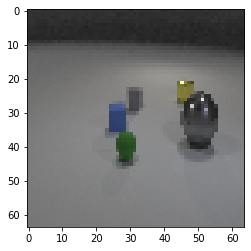

In [16]:
plt.imshow(x[1][0])

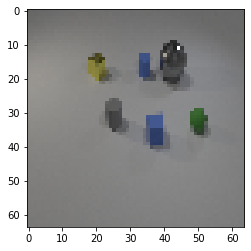

In [17]:
plt.imshow(x_q[1])

In [18]:
x.shape,x_q.shape

(torch.Size([16, 1, 64, 64, 3]), torch.Size([16, 64, 64, 3]))

In [22]:
from attrdict import AttrDict

args = AttrDict({'N':10,'batch_size':16})

__p = lambda x: utils_disco.pack_seqdim(x, args.batch_size)
__u = lambda x: utils_disco.unpack_seqdim(x, args.batch_size)

In [20]:
x = x.permute(0,1,4,2,3)
x_q = x_q.permute(0,3,1,2)

In [1]:
args

NameError: name 'args' is not defined

In [21]:
x_data_, v_data_, label_list = utils_disco.get_cropped_rgb(x, v, metadata, args, __p, __u, context_idx[0])

AssertionError: 

In [21]:
x_q_data_, v_q_data_, label_list_q = utils_disco.get_cropped_rgb(x_q.unsqueeze(1), v_q.unsqueeze(1), metadata, args, __p, __u, context_idx[0])

In [23]:
label_list[100],label_list_q[100]

('cube/cyan_metal', 'cube/cyan_metal')

In [24]:
x_data_.shape,x_q_data_.shape

(torch.Size([106, 1, 3, 64, 64]), torch.Size([106, 1, 3, 64, 64]))

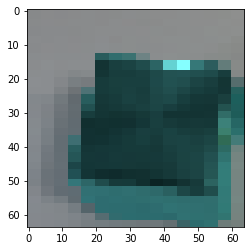

In [18]:
plt.imshow(x_data_[100][0].permute(1,2,0))

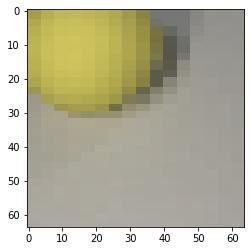

In [19]:
plt.imshow(x_q_data_[100][0].permute(1,2,0))

In [39]:
N = args.N
__pb = lambda x: pack_boxdim(x, N)
__ub = lambda x: unpack_boxdim(x, N)

B = args.batch_size

view_idx = context_idx[0]

In [41]:
x_data, v_data = x,v

In [42]:
from utils_disco import *

In [43]:
gt_boxes_origin_corners = metadata['bbox_origin']
pix_T_cams_raw = metadata['pix_T_cams_raw']
score = metadata['score']
camR_T_origin_raw = metadata['camR_T_origin_raw']
origin_T_camXs_raw = metadata['origin_T_camXs_raw']
object_category = metadata['object_category']

In [44]:
camXs_T_origin = __u(safe_inverse(__p(origin_T_camXs_raw)))
gt_boxes_origin = get_ends_of_corner(gt_boxes_origin_corners)
gt_boxes_origin_end = torch.reshape(gt_boxes_origin,[B,-1,2,3])
gt_boxes_origin_theta = get_alignedboxes2thetaformat(gt_boxes_origin_end)
gt_boxes_origin_corners = transform_boxes_to_corners(gt_boxes_origin_theta, B)

In [45]:
gt_boxesXI_corners = __ub(apply_4x4(camXs_T_origin[:, view_idx], __pb(gt_boxes_origin_corners)))
bbox_camX_ends = get_ends_of_corner(gt_boxesXI_corners)
bbox_camX_theta = get_alignedboxes2thetaformat(bbox_camX_ends)
bbox_camXI_corners = transform_boxes_to_corners(bbox_camX_theta, B)
pix_T_camXI = pix_T_cams_raw[:,view_idx]
bbox_pix_corners = __ub(apply_pix_T_cam(pix_T_camXI, __pb(bbox_camXI_corners)))

In [52]:
rgb_list = []

for b in range(B):
    for n in range(2):
        rgb = x_data[b:b+1,0]
        bbox = bbox_pix_corners[b,n].long()
        _,_,He, Wi = rgb.shape
        
        bbox[:,0] = torch.clamp(bbox[:,0], 0, Wi-1)
        bbox[:,1] = torch.clamp(bbox[:,1], 0, He-1)
        
        xmin, xmax = torch.min(bbox[:,0]).item(), torch.max(bbox[:,0]).item()
        ymin, ymax = torch.min(bbox[:,1]).item(), torch.max(bbox[:,1]).item()
        
        rgb_masked = rgb.clone()
        rgb_masked[:,:,ymin:ymax, xmin:xmax] = 0
        
        cropped_rgb = F.interpolate(rgb[:, :, ymin:ymax, xmin:xmax], (64,64))
        
        rgb_list.append(cropped_rgb[0])

In [64]:
rgb_list[0].shape

torch.Size([3, 64, 64])

In [66]:
x_crops = torch.stack(rgb_list, dim=0)

In [67]:
x_crops.shape

torch.Size([128, 3, 64, 64])

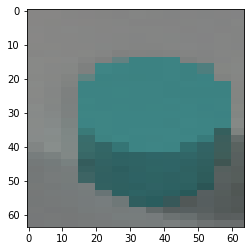

In [65]:
plt.imshow(rgb_list[0].permute(1,2,0))

In [98]:
n

1

In [50]:
x_data.shape

torch.Size([64, 1, 3, 64, 64])

In [59]:
Wi

3

In [69]:
rgb.shape

torch.Size([1, 64, 64, 3])